In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from datetime import timedelta
%matplotlib inline

plt.rcParams["figure.figsize"] = [12, 5]
plt.rcParams["figure.autolayout"] = True

PREFIX="20210625"

In [2]:
# !pip install yfinance

# import yfinance as yf
# IDX = yf.Ticker('INDEX')
# IDX_History = IDX.history(start="2018-01-01", end="2020-09-01")
## IDX_History.head()

# import yfinance as yf
# ZM = yf.Ticker('ZM')
# ZM_History = ZM.history(start="2018-01-01", end="2020-09-01")
## ZM_History.head()

# np.savez_compressed(PREFIX+"_stock_data",idx=IDX_History['Close'],idx_date=IDX_History.index,zm=ZM_History['Close'],zm_date=ZM_History.index)

In [3]:
data = np.load(PREFIX+"_stock_data.npz")

idx = pd.Series(data['idx'],index=data['idx_date'])
zm = pd.Series(data['zm'],index=data['zm_date'])

idx.shape, zm.shape

((671,), (346,))

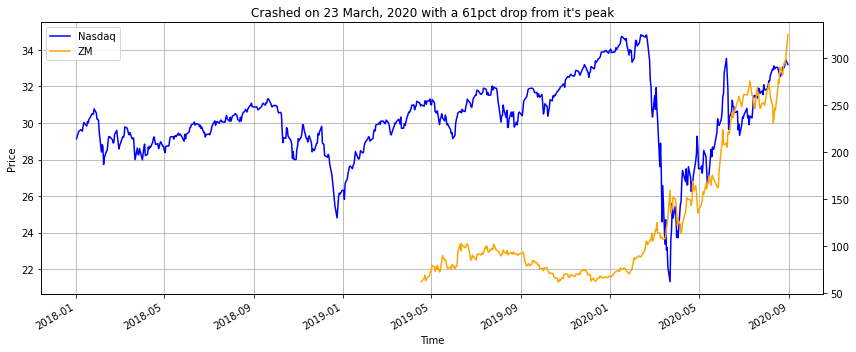

In [4]:
# Calculating crash date
t = idx == max(idx)
_max = idx[t][0]
t = idx == min(idx)
_min = idx[t][0]
crash_date = idx[t].index[0]
_date = dt.strftime(crash_date,"%d %B, %Y")
s = "Crashed on %s with a %dpct drop from it's peak" % (_date, _min/_max*100)

plt.xlabel('Time')
plt.ylabel('Price')

ax1 = idx.plot(color='blue', grid=True, label='Nasdaq')
ax2 = zm.plot(color='orange', grid=True, secondary_y=True, label='ZM')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.title(s)
plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

Variables
   * Number of tranches (3-5)
   * Start of tranches (Jan 2019 to Mar 2020)
   * End of tranches (has to be greater than start by at least `nTranches` weeks & between Jan 2019 to Sept 2020)
   - Nature of tranches - Linear (equal sized tranches as a %age) vs Exponential Decay (power equation). In both cases the tranches will be sold in the same equally spaced time-intervals
   
In our simulation, we can specify all these parameters and calculate the difference in cash generated between a single tranche vs multiple tranches. We will aggregate this data and generate a probability for the particular start date.

If we have reached the crash (23rd March 2020) and we haven't finished our tranches, we will stop there. We were only looking to maximize cash until the crash.

If a tranche date falls on a weekend or public holiday when the markets are closed, we take the next available date

In [154]:
units = 120 # divisble by 3,4,5
nTranches = 3
start = dt(2019,1,1)
end = dt(2020,4,1)
option = ['linear','exponential']
typeTranche = option[0]

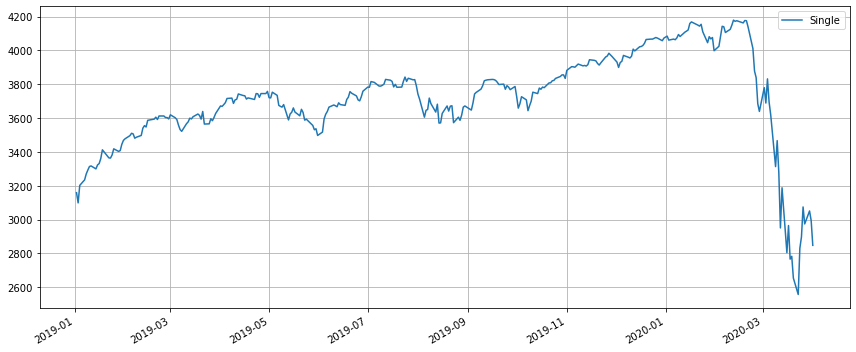

In [155]:
single = idx[(idx.index >= start) & (idx.index <= end)] * units

single.plot(grid=True, label='Single')
plt.legend()

In [158]:
from functools import lru_cache

# distributed 10 points
exp = {
    "3": np.array([5,3,2]),
    "4": np.array([4,3,2,1]),
    "5": np.array([4.5,2.75,1.5,1.25,1])
}

def getSum(s, e, n, t):
    # get the n dates, loop on dates and return sum
    _S = []
    for d in np.linspace(s.toordinal(), e.toordinal(), num=n, dtype=int):
        _S.append(getValueForDate(d))
        
    _S2 = np.array(_S)*exp[str(n)]
        
    return (np.sum(_S), np.sum(_S2)/10)
    
@lru_cache(maxsize=None)
def getValueForDate(d):
    d = dt.fromordinal(d)
    # check if they are before the crash date
    if d >= crash_date:
        return 0
    # get the value for the next available date
    return idx[idx.index>=d][0]
    
fdf = {}
for nTranches in [3,4,5]:
    arr = []
    for sd in pd.date_range(start, crash_date, freq='1d'):
        new_sd = sd + timedelta(days=7*(nTranches-1))
        if new_sd <= end:
#             try:
            a, b = zip(*[getSum(sd,ed,nTranches,typeTranche) for ed in pd.date_range(new_sd, end, freq='1d')])
            arr.append([sd, np.sum(a) / len(a), np.sum(b) / len(b)])
#             except:
#                 print(new_sd, end)
    t = pd.DataFrame(arr)
    fdf[str(nTranches)] = pd.Series(t[1])
    fdf[str(nTranches)].index=t[0]
    fdf[str(nTranches)+"e"] = pd.Series(t[2])
    fdf[str(nTranches)+"e"].index=t[0]

    
df = pd.DataFrame(fdf)
df.to_json(PREFIX+"_computed")

In [165]:
t = pd.read_json(PREFIX+"_computed")
t = t*units
t.head()

,3,3e,4,4e,5,5e
2019-01-01,10449.412692,3400.749960,14072.967150,3438.128791,17735.705185,3776.855590
2019-01-02,10451.901347,3401.420560,14077.886635,3439.229423,17742.778333,3778.341712
2019-01-03,10393.815718,3371.828045,14020.306933,3415.722083,17689.910363,3752.679807
2019-01-04,10499.520990,3424.168120,14128.526569,3458.171651,17799.881104,3800.625661
2019-01-05,10534.177829,3441.019783,14163.801867,3471.871585,17838.597856,3816.606050


In [166]:
single.name="1"
idx.name = "index"

In [167]:
t = t.join(single)

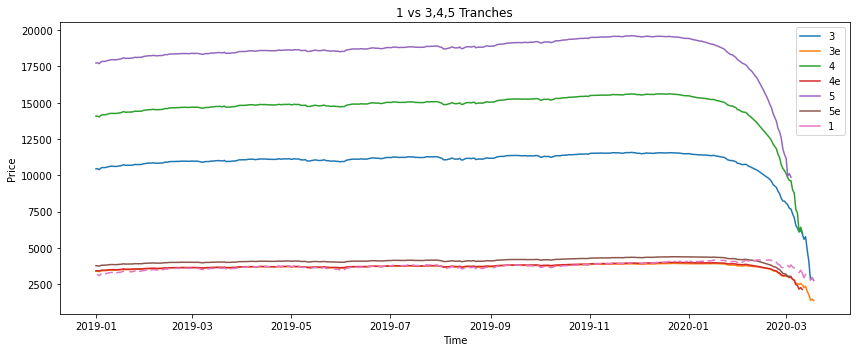

In [168]:
plt.xlabel('Time')
plt.ylabel('Price')

for c in t.columns:
    plt.plot(t[c],label=c)

plt.title("1 vs 3,4,5 Tranches")
plt.legend()
plt.show()

We are seeing a decreasing trend for 3,4,5 tranches near the crash because we have ensured that the tranches at least spread out greater than 1 per week.

You can sell on weekends and that's what the single graph shows. Whereas on the 3,4,5 tranches we have approximated the dates to the next available market day

It looks like exponential doesn't work! We are selling too much when the prices are low